In [ ]:
!pip install -e /home/jovyan/Robbi/dea-notebooks/Tools/

In [ ]:
!pip install pyTMD==2.0.8

In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

os.environ["DEA_TOOLS_TIDE_MODELS"] = "/home/jovyan/tide_models_clipped"
data_path = "/home/jovyan/abslmp"

### BOM tide guage data
http://www.bom.gov.au/oceanography/projects/abslmp/data/index.shtml

In [2]:
def abslmp_gauge(
    site_id="IDO71015",
    coords=None,
    start_year=1990,
    end_year=2023,
    data_path="/gdata1/data/sea_level/abslmp",
    plot=True,
):
    """
    Loads water level data from the nearest Australian Baseline Sea Level
    Monitoring Project gauge.
    """

    # Load station metadata
    site_metadata_df = pd.read_csv(
        f"{data_path}/ABSLMP_station_metadata.csv", index_col="ID CODE"
    )

    if coords is not None:
        from shapely.ops import nearest_points
        from shapely.geometry import Point

        # Standardise coords format
        if isinstance(coords, (xr.core.dataset.Dataset, xr.core.dataarray.DataArray)):
            print("Using dataset bounds to load gauge data")
            coords = coords.odc.geobox.geographic_extent.geom
        elif isinstance(coords, tuple):
            coords = Point(coords)

        # Convert coords to GeoDataFrame
        coords_gdf = gpd.GeoDataFrame(geometry=[coords], crs="EPSG:4326").to_crs(
            "EPSG:3577"
        )

        # Convert metadata to GeoDataFrame
        site_metadata_gdf = gpd.GeoDataFrame(
            data=site_metadata_df,
            geometry=gpd.points_from_xy(
                site_metadata_df.LONGITUDE, site_metadata_df.LATITUDE
            ),
            crs="EPSG:4326",
        ).to_crs("EPSG:3577")

        # Find nearest row
        site_metadata_gdf = gpd.sjoin_nearest(coords_gdf, site_metadata_gdf).iloc[0]

        # Return results
        site_id = site_metadata_gdf["index_right"]
        site_name = site_metadata_gdf["TOWN / DISTRICT"]
        site_ahd = site_metadata_gdf["AHD"]
        site_x = site_metadata_gdf["LONGITUDE"]
        site_y = site_metadata["LATITUDE"]

    # Otherwise, use site ID directly
    elif site_id is not None:
        site_name = site_metadata_df.loc[site_id]["TOWN / DISTRICT"]
        site_ahd = site_metadata_df.loc[site_id]["AHD"]
        site_x = site_metadata_df.loc[site_id]["LONGITUDE"]
        site_y = site_metadata_df.loc[site_id]["LATITUDE"]

    # Read all tide data
    print(f"Loading ABSLMP gauge {site_id} ({site_name})")
    available_paths = glob(f"{data_path}/{site_id}_*.csv")
    available_years = sorted([int(i[-8:-4]) for i in available_paths])
    loaded_data = [
        pd.read_csv(
            f"{data_path}/{site_id}_{year}.csv",
            index_col=0,
            parse_dates=True,
            na_values=-9999,
        )
        for year in range(start_year, end_year)
        if year in available_years
    ]

    try:
        # Combine loaded data
        combined_df = pd.concat(loaded_data).rename(
            {" Adjusted Residuals": "Adjusted Residuals"},
            axis=1,
        )

        # Standardise columns
        combined_df.columns = combined_df.columns.str.lower().str.replace(" ", "_")

        # Extract water level and residuals
        if "adjusted_residuals" in combined_df.columns:
            residuals_col = "adjusted_residuals"
        else:
            print("No adjusted residual data; using raw residuals instead")
            residuals_col = "residuals"
        
        # Compute adjusted metrics
        combined_df = combined_df[["sea_level", residuals_col]].rename_axis("time")       
        combined_df["sea_level"] = combined_df.sea_level - site_ahd
        combined_df["sea_level_noresiduals"] = (
            combined_df.sea_level - combined_df[residuals_col]
        )
        
        # Add site data
        combined_df["site_id"] = site_id
        combined_df["site_name"] = site_name
        combined_df["ahd"] = site_ahd
        combined_df["x"] = site_x
        combined_df["y"] = site_y

        # Summarise non-residual waterlevels by week to assess seasonality
        seasonal_df = (
            combined_df[["sea_level_noresiduals"]]
            .groupby(combined_df.index.isocalendar().week)
            .mean()
        )

        # Plot
        if plot:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            axes = axes.flatten()
            combined_df["sea_level"].plot(ax=axes[0], lw=0.2)
            axes[0].set_title("Water levels (AHD)")
            axes[0].set_xlabel("")
            combined_df[residuals_col].plot(ax=axes[1], lw=0.3)
            axes[1].set_title("Residuals")
            axes[1].set_xlabel("")
            combined_df["sea_level_noresiduals"].plot(ax=axes[2], lw=0.2)
            axes[2].set_title("Water levels, no residuals (AHD)")
            axes[2].set_xlabel("")
            seasonal_df.plot(ax=axes[3])
            axes[3].set_title("Seasonal")

        return combined_df, seasonal_df

    except ValueError:
        print(
            f"\nNo data for selected start and end year. Available years include:\n{available_years}"
        )

In [3]:
# Load station metadata
site_metadata_df = pd.read_csv(
    f"{data_path}/ABSLMP_station_metadata.csv", index_col="ID CODE"
)

In [4]:
out_list = []
for i in site_metadata_df.index:
    site_df, seasonal_df = abslmp_gauge(
        site_id=i,
        start_year=2000,
        end_year=2001,
        data_path=data_path,
        plot=False,
    )
    
    out_list.append(site_df)

combined_df = pd.concat(out_list)

Loading ABSLMP gauge IDO71001 (Townsville - Cape Ferguson)
Loading ABSLMP gauge IDO71002 (Rockhampton - Rosslyn Bay)
Loading ABSLMP gauge IDO71003 (Port Kembla)
Loading ABSLMP gauge IDO71004 (Stony Point)
No adjusted residual data; using raw residuals instead
Loading ABSLMP gauge IDO71006 (Lorne)
No adjusted residual data; using raw residuals instead
Loading ABSLMP gauge IDO71005 (Burnie)
Loading ABSLMP gauge IDO71007 (Triabunna - Spring Bay)
Loading ABSLMP gauge IDO71008 (Portland)
Loading ABSLMP gauge IDO71009 (Adelaide - Port Stanvac)
Loading ABSLMP gauge IDO71010 (Thevenard)
Loading ABSLMP gauge IDO71011 (Esperance)
Loading ABSLMP gauge IDO71012 (Perth - Hillarys)
Loading ABSLMP gauge IDO71013 (Broome)
Loading ABSLMP gauge IDO71014 (Darwin)
Loading ABSLMP gauge IDO71015 (Milner Bay - Groote Eylandt)


In [5]:
from dea_tools.coastal import model_tides

tide_df = model_tides(
    x=combined_df.x,
    y=combined_df.y,
    time=combined_df.index,
    model=[
        "FES2014",
        "FES2012",
        "TPXO8-atlas-v1",
        "TPXO9-atlas-v5",
        "EOT20",
        "HAMTIDE11",
        "GOT4.10",
    ],
    mode="one-to-one",
    parallel_splits=5,
    output_format="wide",
).rename(
    {
        "TPXO9-atlas-v5": "TPXO9",
        "TPXO8-atlas": "TPXO8",
        "TPXO8-atlas-v1": "TPXO8",
    },
    axis=1,
)
tide_df

Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:20<00:00,  1.69it/s]


Converting to a wide format dataframe


,,tide_model,EOT20,FES2012,FES2014,GOT4.10,HAMTIDE11,TPXO8,TPXO9
time,x,y,,,,,,,
2000-01-01 00:00:00,147.058444,-19.277333,0.111980,0.156476,0.123131,0.039711,0.106000,0.130700,0.127113
2000-01-01 01:00:00,147.058444,-19.277333,-0.242835,-0.187586,-0.165334,-0.282486,-0.196926,-0.171084,-0.187783
2000-01-01 02:00:00,147.058444,-19.277333,-0.494243,-0.433761,-0.432381,-0.477638,-0.396064,-0.394158,-0.414244
2000-01-01 03:00:00,147.058444,-19.277333,-0.557080,-0.495482,-0.539066,-0.486549,-0.439058,-0.463015,-0.487092
2000-01-01 04:00:00,147.058444,-19.277333,-0.405751,-0.376511,-0.411465,-0.308025,-0.317365,-0.342181,-0.377617
...,...,...,...,...,...,...,...,...,...
2000-12-31 19:00:00,136.415583,-13.860056,0.616307,0.511713,0.483859,0.476858,0.253689,0.477009,0.524047
2000-12-31 20:00:00,136.415583,-13.860056,0.495067,0.370248,0.351330,0.257818,0.124049,0.404671,0.438353
2000-12-31 21:00:00,136.415583,-13.860056,0.345485,0.211044,0.190515,0.038344,0.001687,0.302951,0.326944


In [ ]:
def tpxo8_tides(x, y, time):
    from otps import TimePoint
    from otps import predict_tide

    # Use the tidal model to compute tide heights for each observation:
    print(f"Modelling tides using OTPS and the TPXO8 tidal model")
    datetimes = time.values.astype("M8[s]").astype("O").tolist()
    if len(np.atleast_1d(x)) > 1:
        timepoints = [
            TimePoint(x_i, y_i, d_i) for d_i, x_i, y_i in zip(datetimes, x, y)
        ]
    else:
        timepoints = [TimePoint(x, y, d_i) for d_i in datetimes]
    tide_predictions = predict_tide(timepoints)
    return [i.tide_m for i in tide_predictions]


# # Add TPXO8 from OTPS
tide_df["TPXO8_otps"] = tpxo8_tides(
    x=combined_df.x[0], y=combined_df.y[0], time=combined_df.index
)

from dea_tools.validation import eval_metrics
eval_metrics(x=tide_df.TPXO8_otps, y=tide_df.TPXO8)


In [6]:
# Add tide gauge data to dataframe
tide_df["site_id"] = combined_df.site_id.values
tide_df["site_name"] = combined_df.site_name.values
tide_df["tide_gauge"] = combined_df.sea_level_noresiduals.values

# Reshape to long format
tide_df_long = tide_df.melt(
    ignore_index=False,
    id_vars=["tide_gauge", "site_id", "site_name"],
    value_vars=[
        "EOT20",
        "FES2012",
        "FES2014",
        "GOT4.10",
        "HAMTIDE11",
        "TPXO9",
        "TPXO8",
    ],
    value_name="tide_m",
)

tide_df_long

,,,tide_gauge,site_id,site_name,tide_model,tide_m
time,x,y,,,,,
2000-01-01 00:00:00,147.058444,-19.277333,0.356,IDO71001,Townsville - Cape Ferguson,EOT20,0.111980
2000-01-01 01:00:00,147.058444,-19.277333,0.029,IDO71001,Townsville - Cape Ferguson,EOT20,-0.242835
2000-01-01 02:00:00,147.058444,-19.277333,-0.234,IDO71001,Townsville - Cape Ferguson,EOT20,-0.494243
2000-01-01 03:00:00,147.058444,-19.277333,-0.331,IDO71001,Townsville - Cape Ferguson,EOT20,-0.557080
2000-01-01 04:00:00,147.058444,-19.277333,-0.201,IDO71001,Townsville - Cape Ferguson,EOT20,-0.405751
...,...,...,...,...,...,...,...
2000-12-31 19:00:00,136.415583,-13.860056,0.607,IDO71015,Milner Bay - Groote Eylandt,TPXO8,0.477009
2000-12-31 20:00:00,136.415583,-13.860056,0.529,IDO71015,Milner Bay - Groote Eylandt,TPXO8,0.404671
2000-12-31 21:00:00,136.415583,-13.860056,0.455,IDO71015,Milner Bay - Groote Eylandt,TPXO8,0.302951


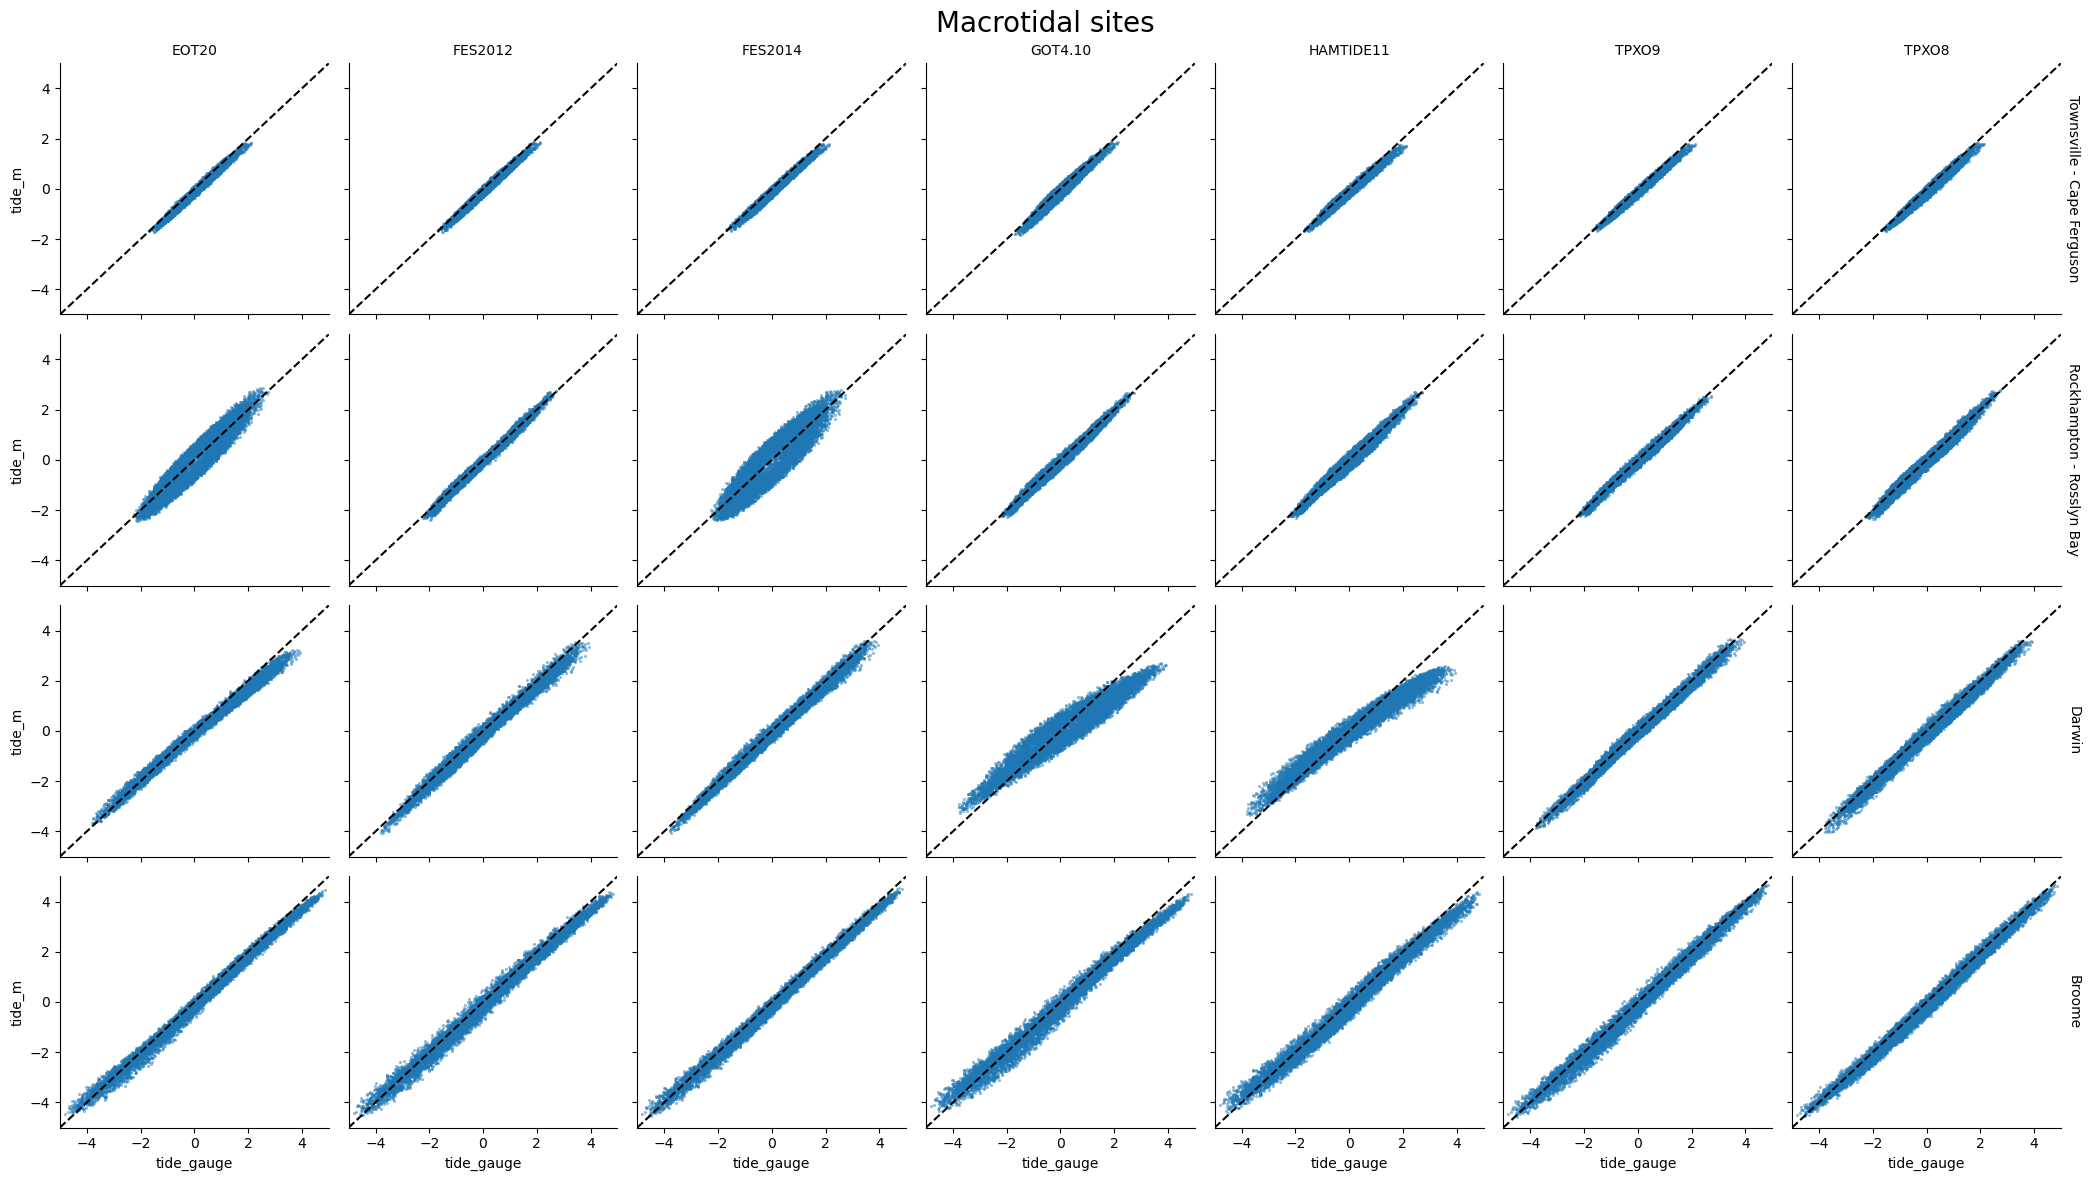

In [108]:
import seaborn as sns

# Calculate tide range per site
tide_range = (
    tide_df_long.groupby("site_id")["tide_gauge"]
    .apply(lambda x: np.abs(x).max())
    .sort_values()
)

# Select subset
sites, limits, title = tide_range.loc[tide_range >= 2], 5, "Macrotidal sites"
# sites, limits, title = tide_range.loc[(tide_range >= 1) & (tide_range < 2)], 2, "Mesotidal sites"
# sites, limits, title = tide_range.loc[tide_range < 1], 1, "Microtidal sites"

# Plot facetted
g = sns.FacetGrid(
    tide_df_long.set_index("site_id").loc[sites.index],
    col="tide_model",
    row="site_name",
    margin_titles=True,
    xlim=(-limits, limits),
    ylim=(-limits, limits),
)
g.fig.suptitle(title, size=20)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.map(sns.scatterplot, "tide_gauge", "tide_m", alpha=0.5, linewidth=0, s=5)
for a in g.axes.flat:
    a.plot([-limits, limits], [-limits, limits], "--", c="black")
g.savefig(f"{title.replace(' ', '')}.jpg")

In [136]:
from dea_tools.validation import eval_metrics

accuracy_df = tide_df_long.groupby(["tide_model", "site_name"])[
    ["tide_gauge", "tide_m"]
].apply(lambda x: eval_metrics(x=x.tide_gauge, y=x.tide_m))

# Best results overall
accuracy_df.loc[
    accuracy_df.groupby("site_name").RMSE.idxmin()
].reset_index().tide_model.value_counts()

EOT20      6
TPXO9      4
FES2014    2
FES2012    2
TPXO8      1
Name: tide_model, dtype: int64

In [ ]:
from shapely.ops import nearest_points
from shapely.geometry import Point
import geopandas as gpd

data_path = "data/raw/ABSLMP"
in_coords = gpd.GeoDataFrame(
    geometry=[Point(119.19939624, -16.58080842)], crs="EPSG:4326"
).to_crs("EPSG:3577")

# Load station metadata
site_metadata_df = pd.read_csv(
    f"{data_path}/ABSLMP_station_metadata.csv", index_col="ID CODE"
)

# Convert to GeoDataFrame
sites_metadata_gdf = gpd.GeoDataFrame(
    data=site_metadata_df,
    geometry=gpd.points_from_xy(site_metadata_df.LONGITUDE, site_metadata_df.LATITUDE),
    crs="EPSG:4326",
).to_crs("EPSG:3577")

# Find nearest row
site_metadata_gdf = gpd.sjoin_nearest(in_coords, sites_metadata_gdf).iloc[0]

# Read all tide data
print(f"Loading data for {site_metadata_gdf['TOWN / DISTRICT']}")
df = pd.concat(
    [
        pd.read_csv(
            f"{data_path}/{site_metadata_gdf.index_right}_{year}.csv",
            index_col=0,
            parse_dates=True,
            na_values=-9999,
        )
        for year in range(2019, 2021)
    ]
)

# Extract water level and residuals
time = slice(None)
water_level = df["Sea Level"][time].dropna() - site_metadata_gdf.AHD
residuals = df["Adjusted Residuals"][time].dropna()
no_residual = water_level - residuals

# Plot
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
water_level.plot(ax=axes[0])
residuals.plot(ax=axes[1])
no_residual.plot(ax=axes[2])

In [ ]:
weekly_correction = no_residual.groupby(no_residual.index.isocalendar().week).mean()
weekly_correction.plot()

In [ ]:
# df = pd.concat([pd.read_csv(f'data/raw/{site}_{year}.csv',
#                             index_col=0,
#                             parse_dates=True,
#                             na_values=-9999)
#                 for year in range(2019, 2021)])

# # Set freq
# df = df.resample("1H").interpolate(method="time")

In [ ]:
# Set optional time slice
time = slice(None)
# time = slice('2015-10', '2016-03')

# Extract water level and residuals
water_level = df['Sea Level'][time].dropna() - site_metadata.AHD
residuals = df['Adjusted Residuals'][time].dropna()
no_residual = water_level - residuals

# Plot
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
water_level.plot(ax=axes[0])
residuals.plot(ax=axes[1])
no_residual.plot(ax=axes[2])

In [ ]:
weekly_correction = no_residual.groupby(no_residual.index.isocalendar().week).mean()
weekly_correction.plot()
# .to_csv('data/raw/weekly_correction.csv')

In [ ]:
doy_mean = no_residual.groupby(no_residual.index.day_of_year).mean()

In [ ]:

from scipy.signal import savgol_filter
plt.plot(weekly_correction)
plt.plot(savgol_filter(weekly_correction, 4, 2))

In [ ]:
weekly_correction.

In [ ]:
pd.concat([doy_mean, doy_mean.iloc[0:50]]).reset_index(drop=True).plot()

In [ ]:
.rolling('2s', min_periods=1).sum()

In [ ]:
no_residual.groupby(no_residual.index.isocalendar().week).mean()

In [ ]:
out = no_residual.groupby(no_residual.index.day_of_year).transform(lambda x: x-x.mean())

In [ ]:
out = no_residual.groupby(no_residual.index.day_of_year).transform(lambda x: x-x.mean())

In [ ]:
out.plot()

In [ ]:
testing['comparison'] = out.values

In [ ]:
testing.plot.scatter(x='tide_m', y='comparison')

In [ ]:
(testing['tide_m'] - testing['comparison']).plot(linewidth=0.05)

In [ ]:
testing['tide_m'].plot(linewidth=0.05)

In [ ]:
testing['comparison'].plot(linewidth=0.05)

In [ ]:
no_residual.index.weekofyear

In [ ]:
import statsmodels.tsa.seasonal as sm_seasonal

In [ ]:
decomposition = sm_seasonal.seasonal_decompose(no_residual)

In [ ]:
out = sm_seasonal.STL(no_residual, trend=181)

In [ ]:
out.fit().plot()

In [ ]:
decomposition.resid.plot()

In [ ]:
decomposition.trend.plot()

In [ ]:
decomposition.trend.plot()

In [ ]:
import scipy as sp
import scipy.fftpack

In [ ]:
no_residual.plot()

In [ ]:
time = water_level.index
residuals = water_level.values

from scipy import fft
import scipy.signal
fft_output = fft.fft(residuals)
power = np.abs(fft_output)
freq = fft.fftfreq(len(residuals))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='signal')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = scipy.signal.find_peaks(power[freq >=0], prominence=10**2.5)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90);


In [ ]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

In [ ]:
filtered_fft_output = np.array([f if i == 1626 else 0 for i, f in enumerate(fft_output)])
filtered_sig = fft.ifft(filtered_fft_output)

N = 24 * 8000
plt.plot(time[:N], water_level[:N], linewidth=1, label='Original signal')
plt.plot(time[:N], filtered_sig[:N].real, linewidth=1, label='Filtered signal')
plt.legend(loc='upper right')
ax2.set_title('First 5 Days')
plt.grid()
plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

In [ ]:
temp = no_residual
# temp = water_level

temp_fft = sp.fftpack.fft(temp.values)

In [ ]:
temp_psd = np.abs(temp_fft) ** 2

In [ ]:
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. / (365.25*24))

In [ ]:
i = fftfreq > 0

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('PSD (dB)')
ax.vlines(1, ymin=-30, ymax=100)

In [ ]:
temp_fft_bis = temp_fft.copy()
temp_fft_bis[np.abs(fftfreq) > 1.1] = 0

In [ ]:
temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# temp.plot(ax=ax, lw=.5)
ax.plot(temp.index, temp_slow, '-')


In [ ]:
temp.plot(ax=ax, lw=.5)

In [ ]:
len(temp_slow)

In [ ]:
(testing['tide_m'] - (df['Sea Level'] - df['Adjusted Residuals']).values).plot(figsize=(10, 5), linewidth=0.2)

Plotting residuals:

In [ ]:
residuals.plot(figsize=(5, 10), linewidth=0.1)
residuals.resample(rule='31D').mean().plot(ax=plt.gca(), linewidth=3)
plt.title('Sea level anomalies, Groote Eylandt, NT')
plt.ylabel('Metres relative to predicted sea level')
plt.ylim(-0.6, 0.6)

In [ ]:
import otps
import pytz

def otps_tides(lats, lons, times, timezone=None):
    """
    Model tide heights for one or more locations and times using the
    OTPS TPXO8 tidal model.
    Parameters:
    -----------
    lats, lons : numeric or list of numeric values
        One or more latitudes and longitude coordinates used to define
        the location at which to model tides.
    times : datetime.datetime or list of datetime.datetimes
        One or more `datatime.datetime` objects providing the times at
        which to model tides. By default these are assumed to be in UTC
        time; if this is not the case, use `timezone` below.
    timezone : string, optional
        If provided `datatime.datetime`s are not in UTC times, use this
        parameter to declare a timezone. E.g. to model tides for times
        expressed in local time at Darwin, Australia, provide
        `timezone='Australia/Darwin'`. Defaults to `None`, which assumes
        provided times are UTC. This is used to convert all times to UTC
        using the `pytz` module. For a full list of timezones, run:
        `import pytz; pytz.all_timezones`.
    Returns:
    --------
    tidepoints_df : pandas.DataFrame
        An `pandas.DataFrame` with a "time" index, "lat" and "lon"
        columns, and a "tide_m" column giving tide heights at each
        point location.
    """

    # Convert to list if provided as individual values
    if not isinstance(lats, list):
        lats = [lats]
    if not isinstance(lons, list):
        lons = [lons]
    if not isinstance(times, list):
        times = [times]

    # If a timezone is provided, localise the input times then
    # standardise to UTC times
    if timezone:
        times = [
            pytz.timezone(timezone).localize(time).astimezone(pytz.utc)
            for time in times
        ]

    # Create list of lat/lon/time scenarios to model tides
    observed_timepoints = [
        otps.TimePoint(lon, lat, time)
        for time in times
        for lon, lat in zip(lons, lats)
    ]

    # Model tides for each lat/lon/time
    observed_predictedtides = otps.predict_tide(observed_timepoints)

    # Output results into pandas.DataFrame
    tidepoints_df = pd.DataFrame(
        [(i.timepoint.timestamp, i.timepoint.lon, i.timepoint.lat, i.tide_m)
         for i in observed_predictedtides],
        columns=['time', 'lon', 'lat', 'tide_m'])

    return tidepoints_df.set_index('time')

In [ ]:
lat, lon = -13.860066, 136.415240

testing = otps_tides(lat, lon, df.index.to_pydatetime().tolist())

### Pytides

In [ ]:
from pytides.tide import Tide

demeaned = water_level - water_level.mean()
tide = Tide.decompose(demeaned, water_level.index)
(demeaned - tide.at(water_level.index)).plot(figsize=(13, 10))